In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
import os
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

In [2]:
# Helper function to print loss function and accuracy history
def history(model):
    plt.figure(figsize = (15, 5) )

    plt.subplot(121)
    plt.plot(model.history['loss'], color='blue', label='train')
    plt.plot(model.history['val_loss'], color='red', label='valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')

    plt.subplot(122)
    plt.plot(model.history['binary_accuracy'], color = 'blue', label='train')
    plt.plot(model.history['val_binary_accuracy'], color='red', label='valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

In [3]:
# Helper function to calculate results
def true_pos(y_true, y_pred):
    return np.sum(y_true * y_pred)


def false_pos(y_true, y_pred):
    return np.sum(y_true * (1. - y_pred))


def false_neg(y_true, y_pred):
    return np.sum((1. - y_true) * y_pred)


def precision(y_true, y_pred):
    return true_pos(y_true, y_pred) / (true_pos(y_true, y_pred) + false_pos(y_true, y_pred))


def recall(y_true, y_pred):
    return true_pos(y_true, y_pred) / (true_pos(y_true, y_pred) + false_neg(y_true, y_pred))


def f1_score(y_true, y_pred):
    return 2. / (1. / recall(y_true, y_pred) + 1. / precision(y_true, y_pred))

### Feature Engineering

In [4]:
import pickle as pickle
with open('train_df.csv', "rb") as fh:
      train_df = pickle.load(fh)

In [5]:
train_df.head()

,features,labels
0,"[[[[197. 158. 103.], [195. 150. 93.], [185. 1...","[1, 2, 3, 4, 5, 6, 7]"
1,"[[[[ 86. 95. 110.], [ 86. 102. 118.], [103. 1...","[1, 2, 3, 4, 5, 6, 7]"
2,"[[[[80. 73. 57.], [81. 74. 58.], [82. 75. 59.]...","[1, 2, 3, 4, 5, 6, 7]"
3,"[[[[137. 157. 168.], [151. 170. 187.], [179. 1...","[1, 2, 3, 4, 5, 6, 7]"
4,"[[[[39. 25. 40.], [36. 28. 43.], [27. 25. 39.]...","[1, 2, 3, 4, 5, 6, 7]"


In [6]:
train_df['new_label'] = [[0]]*19903
for i in range(len(train_df)):
    train_df.at[i, 'new_label'] = [i for i in train_df.loc[i]['labels'] if i in ['0','1','4','5','8']]

In [7]:
nan_list = []
for i in train_df['new_label']:
    if i == []:
        nan_list.append(False)
    else:
        nan_list.append(True)
train_df = train_df[nan_list]
train_df

,features,labels,new_label
0,"[[[[197. 158. 103.], [195. 150. 93.], [185. 1...","[1, 2, 3, 4, 5, 6, 7]","[1, 4, 5]"
1,"[[[[ 86. 95. 110.], [ 86. 102. 118.], [103. 1...","[1, 2, 3, 4, 5, 6, 7]","[1, 4, 5]"
2,"[[[[80. 73. 57.], [81. 74. 58.], [82. 75. 59.]...","[1, 2, 3, 4, 5, 6, 7]","[1, 4, 5]"
3,"[[[[137. 157. 168.], [151. 170. 187.], [179. 1...","[1, 2, 3, 4, 5, 6, 7]","[1, 4, 5]"
4,"[[[[39. 25. 40.], [36. 28. 43.], [27. 25. 39.]...","[1, 2, 3, 4, 5, 6, 7]","[1, 4, 5]"
...,...,...,...
19898,"[[[[153. 80. 35.], [147. 89. 49.], [148. ...","[1, 2, 5, 6, 7]","[1, 5]"
19899,"[[[[32. 31. 39.], [32. 31. 37.], [35. 34. 39.]...","[1, 2, 5, 6, 7]","[1, 5]"
19900,"[[[[5. 3. 6.], [6. 4. 7.], [4. 2. 5.], [4. 2. ...","[1, 2, 5, 6, 7]","[1, 5]"
19901,"[[[[223. 208. 205.], [224. 209. 202.], [226. 2...","[1, 2, 5, 6, 7]","[1, 5]"


In [8]:
train_df = train_df[['features', 'new_label']]

### Modeling

In [9]:
# One-hot encoding of labels
from sklearn.preprocessing import MultiLabelBinarizer

# Process train & test set into an array format
X = np.array([x for x in train_df['features']])
X = np.asarray(X).astype(np.float32)

y = train_df['new_label']
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

# Check shape of array-format train & test set 
print("X: ", X.shape)
print("y: ", y.shape)

X:  (19763, 1, 120, 120, 3)
y:  (19763, 5)


In [10]:
mlb.classes_

array(['0', '1', '4', '5', '8'], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [12]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 120
X_val /= 120

X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3], X_train.shape[4])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[2], X_val.shape[3], X_val.shape[4])

In [13]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (15810, 120, 120, 3)
y_train:  (15810, 5)


In [14]:
epochs = 100
batch_size = 64
n_outputs = y_train.shape[1]

In [16]:
from keras.regularizers import l2
model = Sequential()
model.add(Flatten(input_shape=(120, 120, 3)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.25))
model.add(Dense(n_outputs, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 43200)             0         
                                                                 
 dense (Dense)               (None, 1024)              44237824  
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dense_4 (Dense)             (None, 256)               6

In [17]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.00001, decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['binary_accuracy'])

/Users/WilliamDai/miniforge3/envs/TFmacOS/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/Users/WilliamDai/miniforge3/envs/TFmacOS/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_mlp = model.fit(X_train, y_train, 
                          batch_size=batch_size, 
                          epochs=epochs,
                          validation_data=(X_val, y_val),
                          callbacks=early_stopping_cb)

Epoch 1/100


2022-05-31 16:44:40.836226: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


248/248 [==============================] - 25s 97ms/step - loss: 1.4516 - binary_accuracy: 0.6265 - val_loss: 1.4202 - val_binary_accuracy: 0.6395
Epoch 2/100
248/248 [==============================] - 25s 98ms/step - loss: 1.3979 - binary_accuracy: 0.6399 - val_loss: 1.3689 - val_binary_accuracy: 0.6425
Epoch 3/100
248/248 [==============================] - 24s 97ms/step - loss: 1.3514 - binary_accuracy: 0.6467 - val_loss: 1.3330 - val_binary_accuracy: 0.6500
Epoch 4/100
248/248 [==============================] - 24s 97ms/step - loss: 1.3154 - binary_accuracy: 0.6507 - val_loss: 1.2994 - val_binary_accuracy: 0.6524
Epoch 5/100
248/248 [==============================] - 24s 96ms/step - loss: 1.2840 - binary_accuracy: 0.6542 - val_loss: 1.2714 - val_binary_accuracy: 0.6594
Epoch 6/100
248/248 [==============================] - 25s 99ms/step - loss: 1.2575 - binary_accuracy: 0.6573 - val_loss: 1.2466 - val_binary_accuracy: 0.6592
Epoch 7/100
248/248 [==============================] - 25s

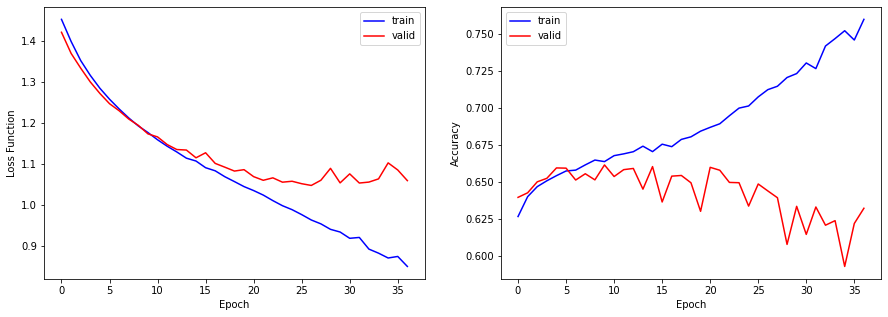

In [19]:
history(history_mlp)

In [20]:
mlp_predictions = (model.predict(X_val) >= 0.5).astype(int)

In [21]:
# F1 Score
mlp_score = f1_score(y_val, mlp_predictions)
print('F1 score: %.5f' % mlp_score)

F1 score: 0.59808


### CNN

In [22]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.00001, decay=1e-6)
cnn = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(120, 120, 3)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Flatten(),
    Dropout(0.25),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(n_outputs, activation='sigmoid')
])

cnn.compile(optimizer = sgd, loss='binary_crossentropy', metrics=['binary_accuracy'])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 128)      

In [23]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_cnn = cnn.fit(X_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(X_val, y_val),
                      callbacks=early_stopping_cb)

Epoch 1/100
248/248 [==============================] - 393s 2s/step - loss: 0.6443 - binary_accuracy: 0.6475 - val_loss: 0.6622 - val_binary_accuracy: 0.6585
Epoch 2/100
248/248 [==============================] - 393s 2s/step - loss: 0.6206 - binary_accuracy: 0.6714 - val_loss: 0.6249 - val_binary_accuracy: 0.6721
Epoch 3/100
248/248 [==============================] - 392s 2s/step - loss: 0.6103 - binary_accuracy: 0.6786 - val_loss: 0.6134 - val_binary_accuracy: 0.6758
Epoch 4/100
248/248 [==============================] - 390s 2s/step - loss: 0.6018 - binary_accuracy: 0.6849 - val_loss: 0.6120 - val_binary_accuracy: 0.6765
Epoch 5/100
248/248 [==============================] - 389s 2s/step - loss: 0.5954 - binary_accuracy: 0.6900 - val_loss: 0.6174 - val_binary_accuracy: 0.6693
Epoch 6/100
248/248 [==============================] - 387s 2s/step - loss: 0.5876 - binary_accuracy: 0.6972 - val_loss: 0.6272 - val_binary_accuracy: 0.6634
Epoch 7/100
248/248 [==============================]

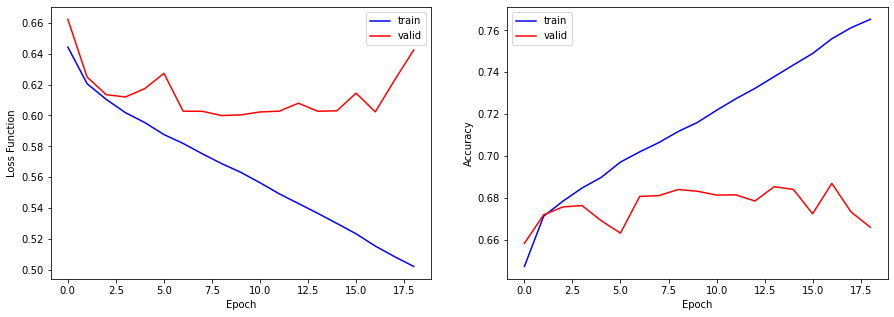

In [24]:
history(history_cnn)

In [25]:
cnn_predictions = (cnn.predict(X_val) >= 0.5).astype(int)

In [26]:
# F1 Score
cnn_score = f1_score(y_val, cnn_predictions)
print('F1 score: %.5f' % cnn_score)

F1 score: 0.65403
